In [18]:
# !pip install hdbscan
# !pip install sentence-transformers
# !pip install umap-learn


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

import hdbscan
from sklearn import metrics


from sentence_transformers import SentenceTransformer
import umap

In [6]:
import warnings
warnings.filterwarnings("ignore")

import os

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# train = pd.read_csv("data/train.csv")
# test = pd.read_csv("data/test.csv")
train_test = pd.concat([train, test], ignore_index=True)

# Aggregate text data and convert it into numerical format

In [10]:
# Aggregate text data by categories, and combine all sentences into one
aggregated_data = train.groupby("category")["text"].apply(lambda x: " ".join(x)).reset_index()

aggregated_data

,category,text
0,Refund_not_showing_up,I don't see my refund money yet in my account....
1,activate_my_card,Please help me with my card. It won't activat...
2,age_limit,I want to open an account for my children How ...
3,apple_pay_or_google_pay,"Hi, I have an apple watch. How do I use it to ..."
4,atm_support,I can use this card at which ATMs? Can I use t...
...,...,...
72,virtual_card_not_working,Why isn't my disposable virtual card working? ...
73,visa_or_mastercard,Is there a way I can have a mastercard? is it ...
74,why_verify_identity,Why do you have an identity check? I do not fe...
75,wrong_amount_of_cash_received,Why did I only receive a partial amount of wha...


In [11]:
model77 = SentenceTransformer('paraphrase-mpnet-base-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
encodings = model77.encode(aggregated_data["text"])

In [15]:
encodings.shape

(77, 768)

In [20]:
umap_embeddings = umap.UMAP(n_neighbors=3,
                            n_components=5,
                            metric='cosine',
                            random_state=None).fit_transform(encodings)

In [22]:
model = hdbscan.HDBSCAN(min_cluster_size=4)
clusters = model.fit_predict(umap_embeddings)

In [23]:
clusters

array([ 2,  2,  4,  4,  3,  4,  1,  1,  2,  2,  3,  3,  3,  3,  2,  2,  0,
        2,  0,  2,  0,  2,  2,  2,  2,  3,  2,  2,  2,  2,  3,  4,  4,  4,
        4,  0,  2,  4,  3,  2,  3,  3,  2,  2,  3,  2,  1,  1,  1,  1,  2,
        4,  2,  2,  4,  2,  3,  3,  4,  2,  3,  2,  4,  2,  0,  4,  1,  4,
       -1,  3,  4,  3,  2,  3,  3,  2,  0])

In [27]:
aggregated_data["topic"] = clusters
aggregated_data

,category,text,topic
0,Refund_not_showing_up,I don't see my refund money yet in my account....,2
1,activate_my_card,Please help me with my card. It won't activat...,2
2,age_limit,I want to open an account for my children How ...,4
3,apple_pay_or_google_pay,"Hi, I have an apple watch. How do I use it to ...",4
4,atm_support,I can use this card at which ATMs? Can I use t...,3
...,...,...,...
72,virtual_card_not_working,Why isn't my disposable virtual card working? ...,2
73,visa_or_mastercard,Is there a way I can have a mastercard? is it ...,3
74,why_verify_identity,Why do you have an identity check? I do not fe...,3
75,wrong_amount_of_cash_received,Why did I only receive a partial amount of wha...,2


In [ ]:
label_dict = dict(aggregated_data.groupby('topic')['category'].unique().apply(list))
label_dict

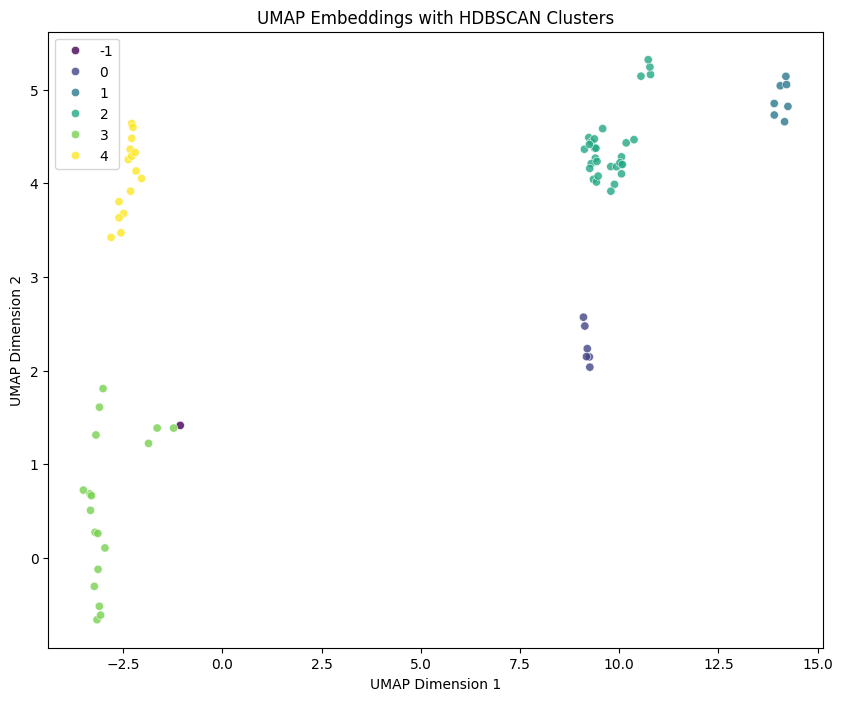

In [32]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=clusters, palette='viridis', legend='full', alpha=0.8)
plt.title('UMAP Embeddings with HDBSCAN Clusters')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()